###Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Import Dependencies

In [2]:
pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 52.4 MB/s eta 0:00:00


In [3]:
pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
from rasterio.plot import plotting_extent
import pyproj as proj

###Set Directories

In [5]:
#path to NAIP image as .tif
naip_image_path = '/content/drive/Shareddrives/WATRS_Field_Data/Student_Projects/B_SanLuis/Shapefiles/NAIP_imagery/m_3612137_ne_10_060_20220514/m_3612137_ne_10_060_20220514.tif'
lat,lon = 36.4593, -121.3877



###Read in and examine what a NAIP image "looks" like

In [6]:
#import NAIP image
naip_image = rxr.open_rasterio(naip_image_path, masked=True)

In [7]:
#look at properties of
naip_image

<xarray.DataArray (band: 4, y: 12380, x: 10200)> Size: 2GB
[505104000 values with dtype=float32]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 82kB 6.397e+05 6.397e+05 ... 6.459e+05 6.459e+05
  * y            (y) float64 99kB 4.041e+06 4.041e+06 ... 4.033e+06 4.033e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0

###Plot raw image

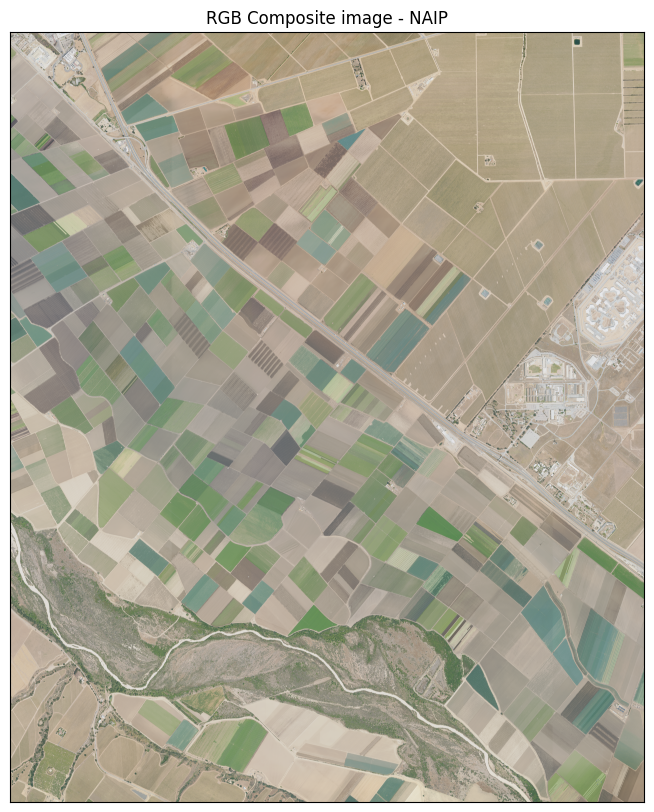

In [8]:
#plot image
ep.plot_rgb(naip_image.values,
            rgb=[0, 1, 2],
            title="RGB Composite image - NAIP")
plt.show()

wow...thats rather big and takes some time to generate. Can I possibly crop this to a smaller extent?

###Hard code in some extent values...this is REALLY slow but valuable as a demonstration

In [9]:
#can I create a polygon that represents only the bottom right corner...this should imclude our fields of interest for lettuce and broccoli!
#maybe start by figuring out the middle points?
print(min(naip_image.y))
print(max(naip_image.y))

<xarray.DataArray 'y' ()> Size: 8B
array(4033410.3)
Coordinates:
    y            float64 8B 4.033e+06
    spatial_ref  int64 8B 0
<xarray.DataArray 'y' ()> Size: 8B
array(4040837.7)
Coordinates:
    y            float64 8B 4.041e+06
    spatial_ref  int64 8B 0


In [ ]:
#okay the middle point should be the algebraic mean of the two...
(4033410.3+4040837.7)/2

4037124.0

In [10]:
#I want the bottom right corner so that should be between the average(top) and minimum(bottom)
top = 4037124.0
bottom = 4033410.3

In [11]:
#do the same for x coord
print(min(naip_image.x))
print(max(naip_image.x))

<xarray.DataArray 'x' ()> Size: 8B
array(639732.3)
Coordinates:
    x            float64 8B 6.397e+05
    spatial_ref  int64 8B 0
<xarray.DataArray 'x' ()> Size: 8B
array(645851.7)
Coordinates:
    x            float64 8B 6.459e+05
    spatial_ref  int64 8B 0


In [12]:
#algebraic mean
left = (639732.3 + 645851.7)/2
right = 645851.7

###Programmatically extract extent values

In [13]:
#hmm this function may extract these values more easily
#this gives us the extent of the ENTIRE image, but we can do
#some easy math to generate the extent for the "bottom-right"
naip_plot_extent = plotting_extent(naip_image[0],
                                   naip_image.rio.transform())

In [14]:
naip_plot_extent

(639732.0, 645852.0, 4033410.0, 4040838.0)

In [15]:
#well...that works too. I can likely grab indivdual values to figure out the left/right/bottom/top values
#of my NAIP image and then programmatically determine the edges of my bounding box
lt = (naip_plot_extent[0]+naip_plot_extent[1])/2

In [16]:
#they're the same...this method is better as it doesn't require me hard coding
print(lt)
print(left)

642792.0
642792.0


In [17]:
#lets make the rest
rt = naip_plot_extent[1]
tp = (naip_plot_extent[2]+naip_plot_extent[3])/2
bt = naip_plot_extent[2]

###Try clipping

In [18]:
#create an object using the clip function using values from above
naip_clip = naip_image.rio.clip_box(
    minx=lt,
    miny=bt,
    maxx=rt,
    maxy=tp,
)

###Plot

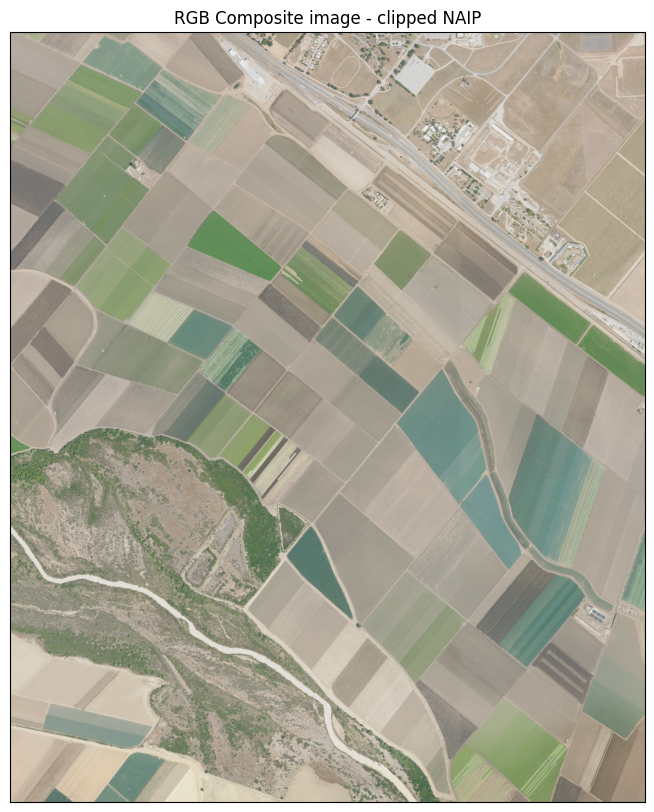

In [19]:
#try plotting again but this time use the clipped object
ep.plot_rgb(naip_clip.values,
            rgb=[0, 1, 2],
            title="RGB Composite image - clipped NAIP")
plt.show()

Okay, that all worked, but what if we want to extract NAIP sections relative to our tower locations?

###get tower location and convert to UTM 10N

In [20]:
#convert tower location coords
station_coord = (lon, lat)
# get EPSG code from lat,long, convert to UTM
EPSG=32700-np.round((45+lat)/90.0)*100+np.round((183+lon)/6.0)
EPSG = int(EPSG)
in_proj = proj.Proj(init='EPSG:4326')
out_proj = proj.Proj(init='EPSG:{}'.format(EPSG))
(station_x,station_y) = proj.transform(in_proj,out_proj,*station_coord)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-20-d879c5043e1f>:8: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  (station_x,station_y) = proj.transform(in_proj,out_

In [21]:
station_x, station_y

(644471.1350075827, 4036101.617475847)

In [22]:
buffer = 300                                                                    # meters from station
st_lt = station_x - buffer
st_rt = station_x + buffer
st_tp = station_y + buffer
st_bt = station_y - buffer

In [23]:
#create an object using the clip function using values from above
naip_clip_station = naip_image.rio.clip_box(
    minx=st_lt,
    miny=st_bt,
    maxx=st_rt,
    maxy=st_tp,
)

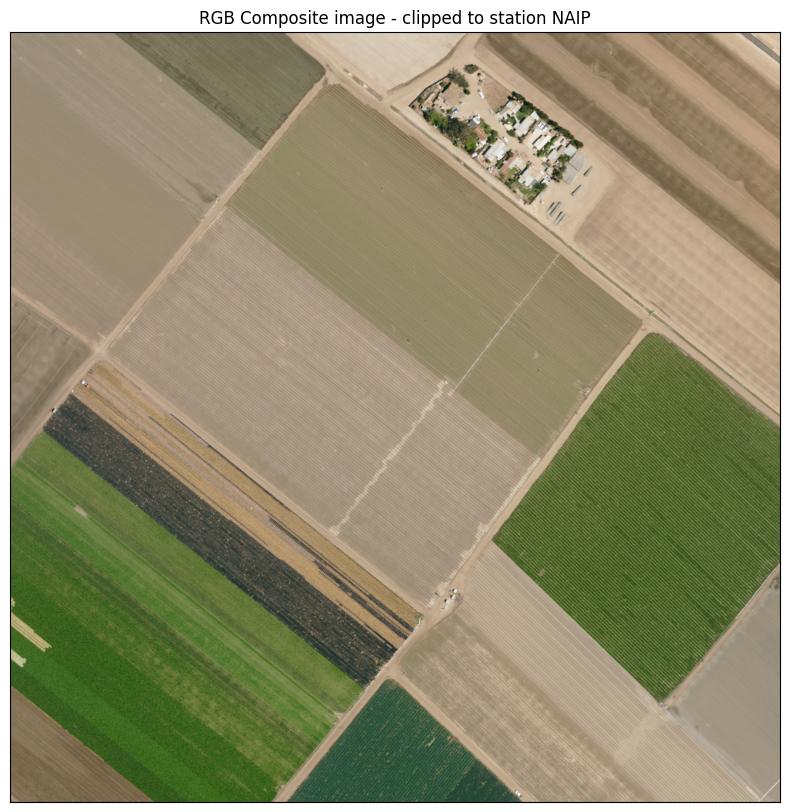

In [24]:
#try plotting again but this time use the clipped to station location object
ep.plot_rgb(naip_clip_station.values,
            rgb=[0, 1, 2],
            title="RGB Composite image - clipped to station NAIP")
plt.show()